In [2]:
import numpy as np
from gensim.models.keyedvectors import KeyedVectors
import networkx as nx
import nltk
from pymorphy2 import MorphAnalyzer
from russian_tagsets import converters

import stopwordsiso as stopwords
from string import punctuation

import matplotlib.pyplot as plt
import re
from collections import Counter
morph = MorphAnalyzer()
to_ud = converters.converter('opencorpora-int', 'ud20')

In [3]:
stops = stopwords.stopwords("ru")
added_stops = {'весь', 'это', 'наш', 'оно', 'итак', 'т.п', 'т.е', 'мало', 'меньше', 'ещё', 'слишком', 'также',
                   'ваш', 'б', 'хм', 'который', 'свой', 'не', 'мочь', 'однако', 'очень', 'благодаря', 'кроме', 'вся',
              'какие', 'ru', 'en', 'млрд', 'млн', 'нет','этот','мной', 'дело', 'был', 'долго', 'наша', 'самих', 'миллионов', 'самых', 'ост', 'ст', 'д', 'проспект', 'компания', 'компании', 'компанию', 'компанией', 'компаниям', 'e-mail',  'шаг', 'ул', 'rus', 'eng', 'проезд', 'площадь', 'cookies', 'куки', 'кг', 'xl', 'rss', 'amp', ';amp', 'pdf', 'doc', 'txt', 'docx', 'i', 'id',
              'бывший'}

stops = stops.union(added_stops)
punct = punctuation+'«»—…“”*№–'

In [4]:
model_path = '/home/mitya/PycharmProjects/nlp_graph/model.bin'
model = KeyedVectors.load_word2vec_format(model_path, binary=True)

In [5]:
def pymorphy_tagger(text):
    text = text.replace('[', ' ').replace(']', ' ')
    parsed = []
    tokens = nltk.word_tokenize(text)
    for word in tokens:
        word = word.strip(punct)
        if (word not in stops) and (word not in punct) and (re.sub(r'[{}]+'.format(punct), '', word).isdigit() is False) and (word != 'nan'):
            lemma = str(morph.parse(word)[0].normal_form)
            pos = to_ud(str(morph.parse(word)[0].tag.POS)).split()[0]
            word_with_tag = lemma + '_' + pos
            parsed.append(word_with_tag)
    return ' '.join(parsed) 


def cosine(a,b):
    dot = np.dot(a, b.T)
    norma = np.linalg.norm(a)
    normb = np.linalg.norm(b)
    cos = dot / (norma * normb)
    return cos 


def similar_words(text, n):
    lst = model.most_similar(pymorphy_tagger(text), topn=n)
    return lst


def diff(text1, text2):
    return cosine(model[text1], model[text2])


def vertices(text, n):
    vertices = similar_words(text, n)
    vertices_list =  [vertices[0] for vertices in vertices]
    return vertices_list


def adjency_mat(vertices_list):
    n = len(vertices_list)
    adj_mat = []
    for i in vertices_list:
    #adj_mat = []
        for j in vertices_list:
            adj_vec = []
            vec = cosine(model[i], model[j])
            adj_vec.append(vec)
            adj_mat.append(adj_vec)
    return np.array(adj_mat).reshape(n, n)    


def draw_graph(mat, vertices_list, th):
    G = nx.from_numpy_matrix(mat)
    mapping = dict(zip(G, vertices_list))    
    H = nx.relabel_nodes(G, mapping)
    labels = nx.get_edge_attributes(H,'weight')
    for (key, value) in labels.items():
        if value <= th:
            labels[key] = 0
    else:
        pass
    pos = nx.spring_layout(H)
    plt.figure()    
    nx.draw(H,pos,edge_color='black',width=1,linewidths=1,\
    node_size=1000,node_color='pink',alpha=0.9,\
    labels={node:node for node in H.nodes()})
    nx.draw_networkx_edge_labels(H,pos=pos, edge_labels=labels)
    plt.show()

In [6]:
n = 5
text = 'свобода'

vertices = similar_words(text, n)


vertices_list =  [vertices[0] for vertices in vertices]

In [7]:
vertices_list

['свобода_ADJ',
 'самостоятельность_NOUN',
 'свобода_PROPN',
 'независимость_NOUN',
 'несвобода_NOUN']

In [8]:
adj_mat = []
for i in vertices_list:
    #adj_mat = []
    for j in vertices_list:
        adj_vec = []
        vec = cosine(model[i], model[j])
        adj_vec.append(vec)
        adj_mat.append(adj_vec)

In [9]:
np.array(adj_mat).reshape(5, 5)

array([[1.0000001 , 0.37957773, 0.38228577, 0.3386654 , 0.42413825],
       [0.37957773, 1.0000001 , 0.17979068, 0.699465  , 0.30720803],
       [0.38228577, 0.17979068, 1.0000001 , 0.28089488, 0.33851472],
       [0.3386654 , 0.699465  , 0.28089488, 0.99999994, 0.26934525],
       [0.42413825, 0.30720803, 0.33851472, 0.26934525, 1.        ]],
      dtype=float32)

In [10]:
G = nx.from_numpy_matrix(np.array(adj_mat).reshape(5, 5))

In [11]:
mapping = dict(zip(G, vertices_list))
H = nx.relabel_nodes(G, mapping)

In [12]:
labels = nx.get_edge_attributes(H,'weight')
pos = nx.spring_layout(H)

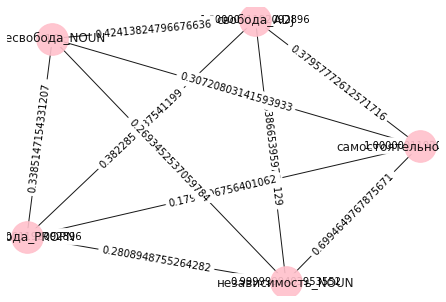

In [13]:
plt.figure()    
nx.draw(H,pos,edge_color='black',width=1,linewidths=1,\
node_size=1000,node_color='pink',alpha=0.9,\
labels={node:node for node in H.nodes()})
nx.draw_networkx_edge_labels(H,pos=pos, edge_labels=labels)
plt.show()

In [38]:
labels_filtered = dict()
for (key, value) in labels.items():
    if value <= 0.3:
        labels_filtered[key] = value
    else:
        pass

In [40]:
labels_filtered.items()

dict_items([(('самостоятельность_NOUN', 'свобода_PROPN'), 0), (('свобода_PROPN', 'независимость_NOUN'), 0), (('независимость_NOUN', 'несвобода_NOUN'), 0)])

In [42]:
def getList(dict): 
    list = [] 
    for key in dict.keys(): 
        list.append(key) 
          
    return list

In [45]:
e

[('самостоятельность_NOUN', 'свобода_PROPN'),
 ('свобода_PROPN', 'независимость_NOUN'),
 ('независимость_NOUN', 'несвобода_NOUN')]

In [48]:
# remove edge with weight <= th

e = getList(labels_filtered)

In [49]:
for element in e:
    H.remove_edge(element)

TypeError: remove_edge() missing 1 required positional argument: 'v'

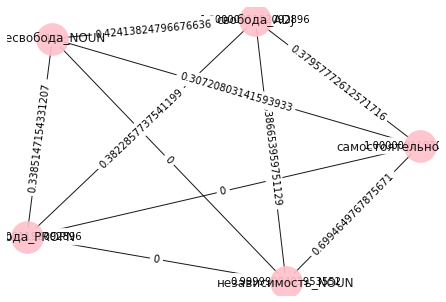

In [16]:
plt.figure()    
nx.draw(H,pos,edge_color='black',width=1,linewidths=1,\
node_size=1000,node_color='pink',alpha=0.9,\
labels={node:node for node in H.nodes()})
nx.draw_networkx_edge_labels(H,pos=pos, edge_labels=labels)
plt.show()

In [17]:
# # pipeline

# vertices = similar_words(text, n)   
#vertices_list =  [vertices[0] for vertices in vertices]    # list of edges

# # adjacency matrix

# delete edge by weight